In [1]:
# from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from joblib import dump
import pandas as pd
import json, os, re, sys

C:\Users\cbreu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [154]:
# Read in the data

df = pd.read_parquet('C:/test/annotated.full.parquet')

In [155]:
# Identify ambiguous data ("conflicting"), and high-confidence pathogenic or benign call

def map_label(s):
    if not isinstance(s, str): return np.nan
    t = s.lower().replace(" ", "_")
    if "conflicting" in t: return -1
    if "pathogenic" in t and "benign" not in t: return 1
    if "benign" in t and "pathogenic" not in t: return 0
    return np.nan

df["label"] = df["clnsig"].apply(map_label)

In [87]:
# Save ambiguous data

amb = df[df["label"] == -1]

amb.to_csv("ambiguous_data_filtered.tsv.gz", sep="\t", index=False,
          na_rep=".", float_format="%.6g", compression="gzip")

In [88]:
# Collect Good data

df = df[df["label"] != -1]

In [89]:
# Copy to training dataset

X = df.copy()

In [90]:
# All remaining columns should be numeric. 
# Double check to ensure numeric dtype

for c in X.columns:
    X[c] = pd.to_numeric(X[c], errors="coerce")

In [91]:
# Predictor column (0/1 for benign/pathogenic)

y = X["label"]

In [93]:
# Drop unneeded columns (target column is 'label' with "benign"/0, "pathogenic"/1)

X = X.drop(["chrom","pos","ref","alt", "label", "feature", "gene", "clnsig", "ccr_top1"], axis =1 )

In [97]:
# Print a rough summary of target column

benign = sum(y==0)
pathogenic = sum(y==1)
total = benign + pathogenic
pct = int(100*(benign/total))

print(f'Number of predictors: \n Benign: {benign} \n Pathogenic: {pathogenic} \n Percent Pathogenic: {pct}')

Number of predictors: 
 Benign: 1263888 
 Pathogenic: 311757 
 Percent Pathogenic: 80


In [98]:
# Set random number seed

randomSeed = 99

In [99]:
# Train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomSeed, stratify=y)

In [100]:
# Pipeline settings

# Pipeline: median imputer -> HistGradientBoosting

pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("clf", HistGradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=None,      # allow tree growth with L2 regularization
        max_leaf_nodes=31,
        l2_regularization=0.0,
        random_state=randomSeed
    ))
])

In [101]:
# Test the effectiveness of the training data + model + params using 5-fold cross validation
    # This creates a model 5x on 5 different train/test splits
    # This does not produce an output model. It only establishes the likelihood the settings will produce a good model.

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=randomSeed)

# Set scoring method
    # ROC AUC - area under the curve - higher = better
    # Average precision - good for cases where the positive value is rare (not the case here, but ok)
scoring = {"roc_auc":"roc_auc", "pr_auc":"average_precision"}

# Test by 5x cross validation
cv_res = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)

In [102]:
# Report CV test results

print(f"[cv] ROC-AUC mean={cv_res['test_roc_auc'].mean():.3f} ± {cv_res['test_roc_auc'].std():.3f}")
print(f"[cv] PR-AUC  mean={cv_res['test_pr_auc'].mean():.3f} ± {cv_res['test_pr_auc'].std():.3f}")

[cv] ROC-AUC mean=0.997 ± 0.000
[cv] PR-AUC  mean=0.989 ± 0.000


In [105]:
# Fit on full train; evaluate on held-out test

pipe.fit(X_train, y_train)
proba = pipe.predict_proba(X_test)[:,1]
preds = (proba >= 0.5).astype(int)

In [106]:
# Check out Proba - probability that each predictor is the positive class (i.e. a "1" == "pathogenic")

preds

array([0, 0, 0, ..., 0, 0, 0])

In [107]:
# Assess model

test_roc = roc_auc_score(y_test, proba)
test_pr  = average_precision_score(y_test, proba)

print(f"[test] ROC-AUC={test_roc:.3f}  PR-AUC={test_pr:.3f}")
print("[test] classification report:")
print(classification_report(y_test, preds, digits=3))

[test] ROC-AUC=0.997  PR-AUC=0.990
[test] classification report:
              precision    recall  f1-score   support

           0      0.988     0.993     0.990    252778
           1      0.971     0.951     0.961     62351

    accuracy                          0.985    315129
   macro avg      0.979     0.972     0.976    315129
weighted avg      0.985     0.985     0.985    315129



In [108]:
# Save the model
pipelineName = "model1.joblib"
dump(pipe, pipelineName)

['model1.joblib']

In [109]:
# Record model features

with open("modelFeatures.txt", "w") as out:
    out.write("Features:\n")
    for f in X.columns:
        out.write(f + "\n")

In [110]:
# Save model scores

with open("modelScores.json", "w") as f:
    json.dump({
        "cv_roc_auc_mean": float(cv_res['test_roc_auc'].mean()),
        "cv_pr_auc_mean": float(cv_res['test_pr_auc'].mean()),
        "test_roc_auc": float(test_roc),
        "test_pr_auc": float(test_pr)
    }, f, indent=2)

print(f"[done] saved model → {'variant_model.joblib'}")
print(f"[done] saved features → {'features.json'}")
print(f"[done] saved metrics → {'metrics.json'}")

[done] saved model → variant_model.joblib
[done] saved features → features.json
[done] saved metrics → metrics.json


In [111]:
# Repair the prediction data to training for confusion matrix

X_test['proba'] = proba
X_test['preds'] = preds
X_test['actual'] = y
X_test["correct"] = (X_test["preds"] == X_test["actual"]).astype(int)

In [112]:
# Get general metrics

totalEntries = len(X_test)
correctEntries = len(X_test[X_test["correct"] == 1])
print(f"Correct: {correctEntries}, Total: {totalEntries}, Percent: {100*(correctEntries/totalEntries)}")

Correct: 310306, Total: 315129, Percent: 98.46951565866678


[Text(0.5, 23.52222222222222, 'Prediction'),
 Text(77.92222222222227, 0.5, 'Actual')]

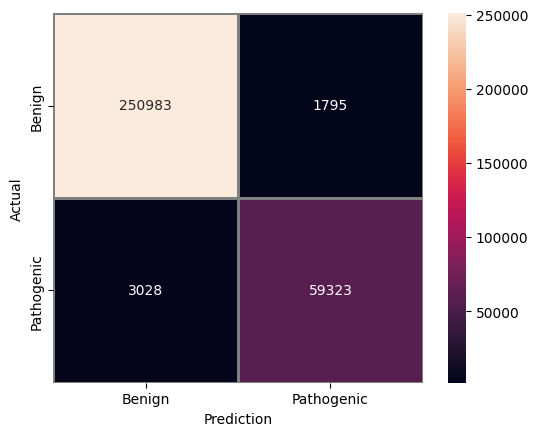

In [115]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(X_test["actual"], X_test["preds"])
cm = pd.DataFrame(cm, index=['0/Benign', '1/Path'], columns=['0/Benign', '1/Path'])

# Confusion Matrix of filtered data
import seaborn as sns

labels = ["Benign","Pathogenic"]
hm = sns.heatmap(cm, annot=True, linecolor='gray', linewidth=1, fmt='', xticklabels=labels, yticklabels=labels, square=True)
hm.set(xlabel='Prediction', ylabel='Actual')

[Text(0.5, 23.52222222222222, 'Prediction'),
 Text(77.92222222222227, 0.5, 'Actual')]

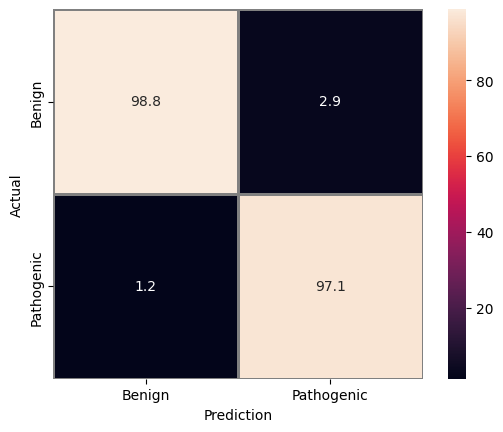

In [116]:
# Convert confusion matrix to percent of total benign or total pathogenic

cSums = list(cm.sum(axis=0))
benTotal = cSums[0]
pathtotal = cSums[1]

bb = round(100*(cm.iloc[0,0]/benTotal),1)
bp = round(100*(cm.iloc[1,0]/benTotal),1)
pb = round(100*(cm.iloc[0,1]/pathtotal),1)
pp = round(100*(cm.iloc[1,1]/pathtotal),1)
cmp = [[bb, pb], [bp, pp]]
cm2 = pd.DataFrame(cmp, index=['Pathogenic', 'Benign'], columns=['Pathogenic', 'Benign'])

# Plot confusion matrix as percent

labels = ["Benign","Pathogenic"]
hm = sns.heatmap(cm2, annot=True, linecolor='gray', linewidth=1, fmt='', xticklabels=labels, yticklabels=labels, square=True)
hm.set(xlabel='Prediction', ylabel='Actual')

# **Predict the effect of ambiguous mutations**

In [147]:
# Use the model to predict the ambiguous data effects

amb = pd.read_csv("ambiguous_data_filtered.tsv.gz", sep="\t", compression="gzip")

In [148]:
# Split off predictors

X = amb.drop(["chrom", "pos", "ref", "alt", "label", "clnsig", "feature", "gene", "label", "ccr_top1"], axis=1)

# Ensure data is numeric
for c in X.columns:
    X[c] = pd.to_numeric(X[c], errors="coerce")

In [149]:
# Predict

proba = pipe.predict_proba(X)[:, 1] 
pred  = (proba >= 0.5).astype(int)    # prediction threshold

# Append results to output data
amb["probability"] = proba
amb["prediction"] = pred

In [153]:
# Pathogenicity predictions

amb.to_csv("ambiguous_data_predictions.tsv.gz", sep="\t", index=False,
          na_rep=".", float_format="%.6g", compression="gzip")

# **Create a small, general model**

In [156]:
# Read in the data as before and reprocess it (same as initial processing)

df = pd.read_parquet('C:/test/annotated.full.parquet')

# Convert clnsig to 0/1 for benigh/pathogenic
df["label"] = df["clnsig"].apply(map_label)

# Get rid of ambiguous data
df = df[df["label"] != -1]

# Copy
X = df.copy()

# Coerce to numeric
for c in X.columns:
    X[c] = pd.to_numeric(X[c], errors="coerce")

# Collect prediction column
y = X["label"]

In [157]:
# Drop most columns - only keep those that can be inferred from CHROM, POS, REF, ALT

# Drop unneeded columns (target column is 'label' with "benign"/0, "pathogenic"/1)
X = X.drop(["chrom","pos","ref","alt", "label", "clnsig", "feature", "gene"], axis =1 )

# Drop data columns that can't be calculated or inferred from CHROM, POS, REF, ALT 
X = X.drop(["af","nhomalt","revel","cadd_phred","cadd_raw","mpc","phyloP100","phastCons100","gerp_rs","ccr_pct", "ccr_top1", "mpc_filled", "mpc_is_missing"], axis =1 )

In [159]:
# Print a rough summary of target column

benign = sum(y==0)
pathogenic = sum(y==1)
total = benign + pathogenic
pct = int(100*(float(pathogenic/total)))

print(f'Number of predictors: \n Benign: {benign} \n Pathogenic: {pathogenic} \n Percent Pathogenic: {pct}')

Number of predictors: 
 Benign: 1263888 
 Pathogenic: 311757 
 Percent Pathogenic: 19


In [160]:
# Train/test split

randomSeed = 99
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomSeed, stratify=y)

In [162]:
# Pipeline settings (same as before)

# Pipeline: median imputer -> HistGradientBoosting

pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("clf", HistGradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=None,      # allow tree growth with L2 regularization
        max_leaf_nodes=31,
        l2_regularization=0.0,
        random_state=randomSeed
    ))
])

In [163]:
# Test the effectiveness of the training data + model + params using 5-fold cross validation
    # This creates a model 5x on 5 different train/test splits
    # This does not produce an output model. It only establishes the likelihood the settings will produce a good model.

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=randomSeed)

# Set scoring method
    # ROC AUC - area under the curve - higher = better
    # Average precision - good for cases where the positive value is rare (not the case here, but ok)
scoring = {"roc_auc":"roc_auc", "pr_auc":"average_precision"}

# Test by 5x cross validation
cv_res = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)

In [164]:
# Report CV test results

print(f"[cv] ROC-AUC mean={cv_res['test_roc_auc'].mean():.3f} ± {cv_res['test_roc_auc'].std():.3f}")
print(f"[cv] PR-AUC  mean={cv_res['test_pr_auc'].mean():.3f} ± {cv_res['test_pr_auc'].std():.3f}")

[cv] ROC-AUC mean=0.886 ± 0.001
[cv] PR-AUC  mean=0.754 ± 0.002


In [165]:
# Fit on full train; evaluate on held-out test

pipe.fit(X_train, y_train)
proba = pipe.predict_proba(X_test)[:,1]
preds = (proba >= 0.5).astype(int)

In [166]:
# Assess model

test_roc = roc_auc_score(y_test, proba)
test_pr  = average_precision_score(y_test, proba)

print(f"[test] ROC-AUC={test_roc:.3f}  PR-AUC={test_pr:.3f}")
print("[test] classification report:")
print(classification_report(y_test, preds, digits=3))

[test] ROC-AUC=0.885  PR-AUC=0.755
[test] classification report:
              precision    recall  f1-score   support

           0      0.906     0.956     0.931    252778
           1      0.771     0.599     0.674     62351

    accuracy                          0.885    315129
   macro avg      0.839     0.778     0.802    315129
weighted avg      0.879     0.885     0.880    315129



In [167]:
# Save the model
pipelineName = "smallModel.joblib"
dump(pipe, pipelineName)

['smallModel.joblib']

In [168]:
# Record model features

with open("smallModelFeatures.txt", "w") as out:
    out.write("Features:\n")
    for f in X.columns:
        out.write(f + "\n")

In [169]:
# Save model scores

with open("smallModelScores.json", "w") as f:
    json.dump({
        "cv_roc_auc_mean": float(cv_res['test_roc_auc'].mean()),
        "cv_pr_auc_mean": float(cv_res['test_pr_auc'].mean()),
        "test_roc_auc": float(test_roc),
        "test_pr_auc": float(test_pr)
    }, f, indent=2)

print(f"[done] saved model → {'variant_model.joblib'}")
print(f"[done] saved features → {'features.json'}")
print(f"[done] saved metrics → {'metrics.json'}")

[done] saved model → variant_model.joblib
[done] saved features → features.json
[done] saved metrics → metrics.json


In [170]:
# Get the original data for the X_test rows

r = X_test
r["proba"] = proba
r["preds"] = preds
r["actual"] = y_test

In [172]:
# Accuracy
r["correct"] = (r["preds"] == r["actual"]).astype(int)
r.head()

,loeuf,pli,mis_z,syn_z,ref_len,alt_len,is_indel,is_snv,indel_len,is_transition_num,...,is_frameshift,is_missense,mt_missense,mt_noncoding,mt_nonsense,mt_silent,proba,preds,actual,correct
368061,NaN,NaN,4.233300,1.09160,1,1,0,1,0,1,...,0,0,0,1,0,0,0.083532,0,0,1
1654540,NaN,NaN,NaN,NaN,1,1,0,1,0,1,...,0,0,0,1,0,0,0.097363,0,1,0
402877,0.803,6.586100e-44,1.021800,1.54670,1,1,0,1,0,0,...,0,0,0,1,0,0,0.239626,0,0,1
986498,NaN,NaN,-0.062263,0.10622,1,1,0,1,0,1,...,0,0,0,1,0,0,0.072867,0,0,1
434189,0.304,9.999900e-01,3.754000,0.18436,1,1,0,1,0,0,...,0,0,0,1,0,0,0.150353,0,0,1


In [173]:
# Get general metrics

totalEntries = len(r)
correctEntries = len(r[r["correct"] == 1])
print(f"Correct: {correctEntries}, Total: {totalEntries}, Percent: {100*(correctEntries/totalEntries)}")

Correct: 279032, Total: 315129, Percent: 88.5453258824164


In [174]:
# Filter to high confidence

f = r[(r['proba'] > 0.75) | (r['proba'] < 0.25)]
print(f"Final length of high confidence mutation list: {len(f)}, pct. of total: {(len(f)/len(r))*100}")

Final length of high confidence mutation list: 271756, pct. of total: 86.23643016034703


In [175]:
# Get general metrics for filtered (high confidence) predictions

totalF = len(f)
correctF = len(f[f["correct"] == 1])
print(f"Correct: {correctF}, Total: {totalF}, Percent: {100*(correctF/totalF)}")

Correct: 251218, Total: 271756, Percent: 92.44248517052061


In [176]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(f["actual"], f["preds"])
cm = pd.DataFrame(cm, index=['0/Benign', '1/Path'], columns=['0/Benign', '1/Path'])

[Text(0.5, 23.52222222222222, 'Prediction'),
 Text(77.92222222222227, 0.5, 'Actual')]

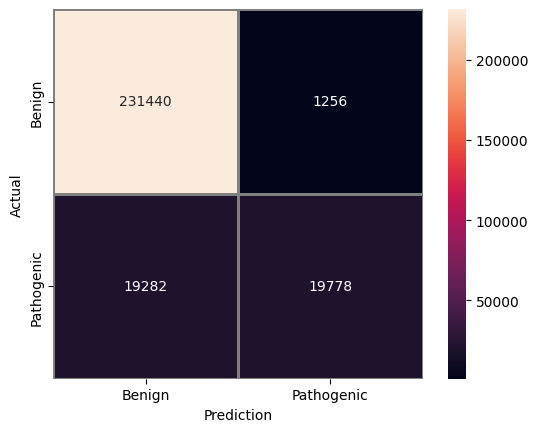

In [177]:
# Confusion Matrix of filtered data
import seaborn as sns

labels = ["Benign","Pathogenic"]
hm = sns.heatmap(cm, annot=True, linecolor='gray', linewidth=1, fmt='', xticklabels=labels, yticklabels=labels, square=True)
hm.set(xlabel='Prediction', ylabel='Actual')

In [178]:
# Convert confusion matrix to percent of total benign or total pathogenic

cSums = list(cm.sum(axis=0))
benTotal = cSums[0]
pathtotal = cSums[1]

bb = round(100*(cm.iloc[0,0]/benTotal),1)
bp = round(100*(cm.iloc[1,0]/benTotal),1)
pb = round(100*(cm.iloc[0,1]/pathtotal),1)
pp = round(100*(cm.iloc[1,1]/pathtotal),1)
cmp = [[bb, pb], [bp, pp]]
cm2 = pd.DataFrame(cmp, index=['Pathogenic', 'Benign'], columns=['Pathogenic', 'Benign'])

[Text(0.5, 23.52222222222222, 'Prediction'),
 Text(77.92222222222227, 0.5, 'Actual')]

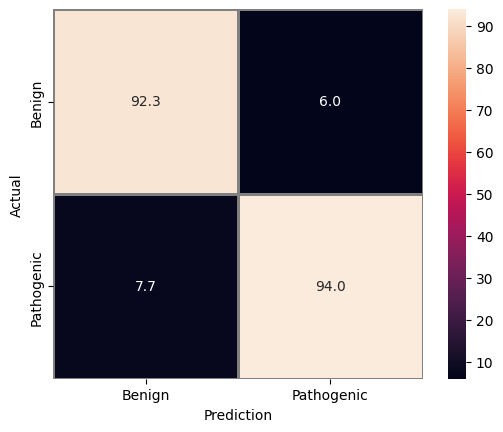

In [179]:
# Plot confusion matrix as percent

labels = ["Benign","Pathogenic"]
hm = sns.heatmap(cm2, annot=True, linecolor='gray', linewidth=1, fmt='', xticklabels=labels, yticklabels=labels, square=True)
hm.set(xlabel='Prediction', ylabel='Actual')

[Text(0.5, 23.52222222222222, 'Prediction'),
 Text(77.92222222222227, 0.5, 'Actual')]

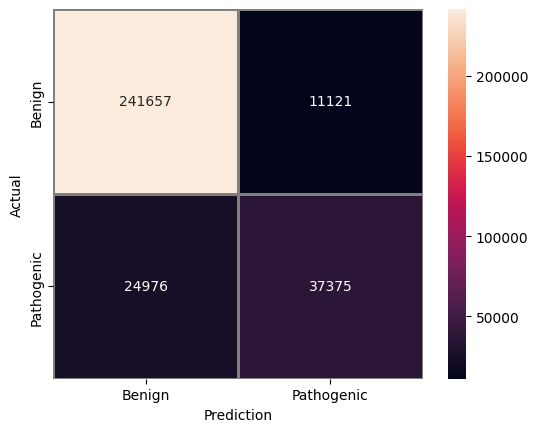

In [181]:
# Full set of predictions (without filtering for high confidence)
# Plot confusion matrix as percent

cm = confusion_matrix(r["actual"], r["preds"])
cm = pd.DataFrame(cm, index=['0/Benign', '1/Path'], columns=['0/Benign', '1/Path'])

labels = ["Benign","Pathogenic"]
hm = sns.heatmap(cm, annot=True, linecolor='gray', linewidth=1, fmt='', xticklabels=labels, yticklabels=labels, square=True)
hm.set(xlabel='Prediction', ylabel='Actual')

[Text(0.5, 23.52222222222222, 'Prediction'),
 Text(77.92222222222227, 0.5, 'Actual')]

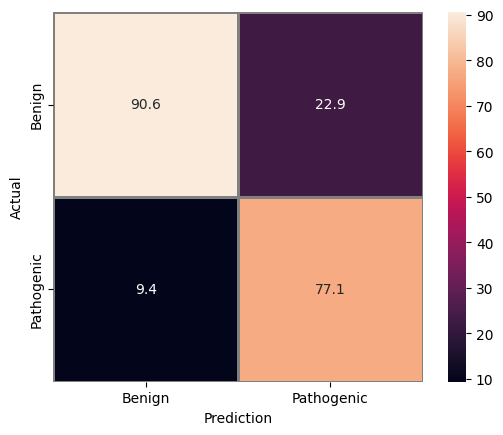

In [182]:
# Convert unfiltered data to percent of total benign or total pathogenic

cSums = list(cm.sum(axis=0))
benTotal = cSums[0]
pathtotal = cSums[1]

bb = round(100*(cm.iloc[0,0]/benTotal),1)
bp = round(100*(cm.iloc[1,0]/benTotal),1)
pb = round(100*(cm.iloc[0,1]/pathtotal),1)
pp = round(100*(cm.iloc[1,1]/pathtotal),1)
cmp = [[bb, pb], [bp, pp]]
cm2 = pd.DataFrame(cmp, index=['Pathogenic', 'Benign'], columns=['Pathogenic', 'Benign'])

# Plot confusion matrix as percent

labels = ["Benign","Pathogenic"]
hm = sns.heatmap(cm2, annot=True, linecolor='gray', linewidth=1, fmt='', xticklabels=labels, yticklabels=labels, square=True)
hm.set(xlabel='Prediction', ylabel='Actual')